In [0]:
!pip install nltk
!pip install emoji
!pip install twitterscraper

import csv
import numpy as np
import emoji
import nltk
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files
from nltk.tokenize import word_tokenize
from sklearn.metrics import confusion_matrix
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
np.random.seed(1)
nltk.download('punkt')

%matplotlib inline

In [0]:
df_train = pd.read_csv('train_data')

In [0]:
emoji_dictionary = {"0": "\u2764\uFE0F",    
                    "1": ":smile:",
                    "2": ":disappointed:",
                    "3": ":pleading_face:",
                    "4": ":face_with_steam_from_nose:",
                    }

In [0]:
X_sentences = df_train["text"].to_numpy()
Y = df_train["label"].to_numpy()

In [25]:
words_to_embeddings = {}
word_to_index = {}
index_to_word = {}
words = set()
with open('glove.6B.50d.txt') as f:
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            words_to_embeddings[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        for w in sorted(words):
            word_to_index[w] = i
            index_to_word[i] = w
            i = i + 1

print('Found %s word vectors.' % len(words_to_embeddings))

Found 400000 word vectors.


In [64]:
max_len = 0
X_tokens = []
for sentences in X_sentences:
  tokens = word_tokenize(sentences.lower().replace('\n', ' '))
  length = len(tokens)
  if length > max_len:
    max_len = length
  X_tokens.append(tokens)

print('length of longest tweet is %s tokens.'  %max_len)

length of longest tweet is 79 tokens.


In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(X_tokens, Y, test_size=0.33, random_state=42)

In [0]:
def tokens_to_indices(X_tokens, word_to_index, max_len):
  m = len(X_tokens) 
  X_indices = np.zeros((m, max_len))

  for i in range(m):
    sentence_tokens = X_tokens[i]
    j = 0
    for token in sentence_tokens:
      if token in word_to_index.keys():
        X_indices[i,j] = word_to_index[token]
      else:
        X_indices[i,j] = word_to_index["unk"]
      j += 1

  return X_indices

In [0]:
def label_to_one_hot(Y, num_classes):
    Y = np.eye(num_classes)[Y.reshape(-1)]
    return Y

In [0]:
def embedding_layer(words_to_embeddings, word_to_index):
  num_words = len(word_to_index) + 1 #additional row for <unk>
  embedding_dim = 50 

  embedding_matrix = np.zeros((num_words, embedding_dim))

  for word, index in word_to_index.items():
    embedding_matrix[index, :] = words_to_embeddings[word]
  
  embedding_layer = Embedding(num_words, embedding_dim, trainable=False)
  embedding_layer.build((None,))
  embedding_layer.set_weights([embedding_matrix])

  return embedding_layer

In [0]:
embedding_layer = embedding_layer(words_to_embeddings, word_to_index)

In [0]:
def build_model():
  sentence_indices = Input(shape=(max_len,), dtype='int32')
  embeddings = embedding_layer(sentence_indices)   
  X = LSTM(128, return_sequences=True)(embeddings)
  X = Dropout(rate=0.5)(X)
  X = LSTM(128, return_sequences=False)(X)
  X = Dropout(rate=0.5)(X)
  X = Dense(5)(X)
  preds = Activation('softmax')(X)
  model = Model(sentence_indices, preds)
  opt = Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, amsgrad=False)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

X_train_indices = tokens_to_indices(X_train, word_to_index, max_len)
X_val_indices = tokens_to_indices(X_val, word_to_index, max_len)
Y_train_oh = label_to_one_hot(Y_train, 5)
Y_val_oh = label_to_one_hot(Y_val, 5)

X_subset = X_train_indices[:1000]
Y_subset = Y_train_oh[:1000]

params = {'epochs': [50, 100, 200]}
search_model = KerasClassifier(build_fn=build_model)
grid = GridSearchCV(estimator=search_model, param_grid=params, cv=3)
grid_result = grid.fit(X_subset, Y_subset)

In [0]:
grid_result.best_params_

{'epochs': 100}

In [0]:
model = build_model()
history = model.fit(X_train_indices, Y_train_oh, validation_data=(X_val_indices, Y_val_oh), epochs = 100, batch_size = 32, shuffle=True)

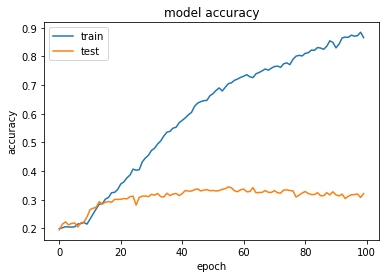

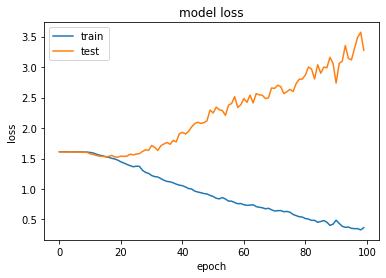

In [73]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
def label_to_emoji(label):
    return emoji.emojize(emoji_dictionary[str(label)], use_aliases=True)

In [0]:
def sentence_to_indices(sentence, word_to_index, max_len):
  x_tokens = word_tokenize(sentence.lower().replace('\n', ' '))
  x_indices = np.zeros(max_len)
  i = 0
  for token in x_tokens:
    if token in word_to_index.keys():
      x_indices[i] = word_to_index[token]
    else:
      x_indices[i] = word_to_index["unk"]
    i += 1
  x_indices = x_indices.reshape((1,max_len))
  return x_indices

In [77]:
x_test = "I'm sad"
x_indices = sentence_to_indices(x_test, word_to_index, max_len)
print(x_test +' '+  label_to_emoji(np.argmax(model.predict(x_indices))))

I'm sad 😞
